In [1]:
import pandas as pd 
import numpy as np 
import os 
import sys 
import matplotlib.pyplot as plt 
import seaborn as sns 

from IPython.display import display

# Dictionnaire 

                        * store_id = magasin
                        * item_id = produit 
                        * dept_id = catégorie 
                        * cat_id = marché 
                        * state_id = état (tx=texas, ca=californie, wi=winconscin)
                        * id = item_id + "_" + store_id + "_" + [identifiant : validation/evaluation] (vous pouvez ignorer l'identifiant)

                        * d_1 ... d_1913 = jours
                        * wm_yr_wk = identifiant de la semaine 
                        * sell_price = prix du produit dans son magasin pour un wm_yr_wk donné

                        * event_name1/2 = événements (ex. SuperBowl)
                        * event_name 1/2 = typologie d'événements
                        * snap[ca/tx/wi] = ce jour est promotionnel 

            

In [2]:
prices = pd.read_csv(r"C:\Users\pc\Desktop\mes dossiers\COURS 2023-2024\DEUXIEME SEMESTRE\PYTHON\PROJET_2024\test\m5_forecast_price_dataset.csv")
sales = pd.read_csv(r"C:\Users\pc\Desktop\mes dossiers\COURS 2023-2024\DEUXIEME SEMESTRE\PYTHON\PROJET_2024\test\m5_forecast_sales_dataset.csv")
calendar = pd.read_csv(r"C:\Users\pc\Desktop\mes dossiers\COURS 2023-2024\DEUXIEME SEMESTRE\PYTHON\PROJET_2024\test\m5_forecast_calendar_dataset.csv")

display(
    prices.head(1),
    sales.head(1),
    calendar.head(1)
)

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_006,11210,1.0


,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_006_CA_1_validation,HOBBIES_1_006,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,0,1,0,0,0,2,0,0


,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0


# étape n°1 : dé-pivoter les ventes

In [3]:
categorical = ['id', 'item_id', 'store_id', 'cat_id', 'dept_id', 'state_id']
dcols = [x for x in sales.columns if x not in categorical]

flatten_sales = pd.melt(
    sales, 
    id_vars=categorical, 
    value_vars=dcols,
    var_name="d",
    value_name="ventes"
)

flatten_sales.head()

,id,item_id,store_id,cat_id,dept_id,state_id,d,ventes
0,HOBBIES_1_006_CA_1_validation,HOBBIES_1_006,CA_1,HOBBIES,HOBBIES_1,CA,d_1,0
1,HOBBIES_1_015_CA_1_validation,HOBBIES_1_015,CA_1,HOBBIES,HOBBIES_1,CA,d_1,4
2,HOBBIES_1_016_CA_1_validation,HOBBIES_1_016,CA_1,HOBBIES,HOBBIES_1,CA,d_1,5
3,HOBBIES_1_023_CA_1_validation,HOBBIES_1_023,CA_1,HOBBIES,HOBBIES_1,CA,d_1,2
4,HOBBIES_1_025_CA_1_validation,HOBBIES_1_025,CA_1,HOBBIES,HOBBIES_1,CA,d_1,0


# etape n°2 : joindre le calendrier & les prix 

In [4]:
flatten_sales = pd.merge(flatten_sales, calendar, how="inner", on=["d"])

display(
    flatten_sales.head(1),
    prices.head(1)
)

,id,item_id,store_id,cat_id,dept_id,state_id,d,ventes,date,wm_yr_wk,...,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,HOBBIES_1_006_CA_1_validation,HOBBIES_1_006,CA_1,HOBBIES,HOBBIES_1,CA,d_1,0,2011-01-29,11101,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0


,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_006,11210,1.0


In [5]:
flatten_sales = pd.merge(flatten_sales, prices, how="left", on=["store_id", "item_id", "wm_yr_wk"])
flatten_sales.head(2)

,id,item_id,store_id,cat_id,dept_id,state_id,d,ventes,date,wm_yr_wk,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_006_CA_1_validation,HOBBIES_1_006,CA_1,HOBBIES,HOBBIES_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
1,HOBBIES_1_015_CA_1_validation,HOBBIES_1_015,CA_1,HOBBIES,HOBBIES_1,CA,d_1,4,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,0.7


In [6]:
flatten_sales['sell_price'].isnull().sum() / len(flatten_sales)

0.22830889675854968

# etape n°3 : filtrez les faux départs de séries temporelles 

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Convertir la colonne 'date' en datetime si ce n'est pas déjà fait
flatten_sales['date'] = pd.to_datetime(flatten_sales['date'])

# Agréger les ventes par mois et par année
ventes_mensuelles = flatten_sales.groupby([flatten_sales['date'].dt.year, flatten_sales['date'].dt.month])['ventes'].sum()
ventes_annuelles = ventes_mensuelles.groupby(level=0).sum()

# Calculer les variations mensuelles et annuelles
variations_mensuelles = ventes_mensuelles.diff()
variations_annuelles = ventes_annuelles.diff()

In [8]:
true_start = (flatten_sales.loc[flatten_sales['ventes'] >0]
              .groupby(['store_id', 'item_id'])
              .agg(min_date=('date', 'min'))
)

true_start.head(5)

min_date
store_id item_id               
CA_1     FOODS_1_005 2011-01-29
         FOODS_1_012 2011-07-31
         FOODS_1_013 2011-01-29
         FOODS_1_026 2011-04-09
         FOODS_1_029 2011-04-05

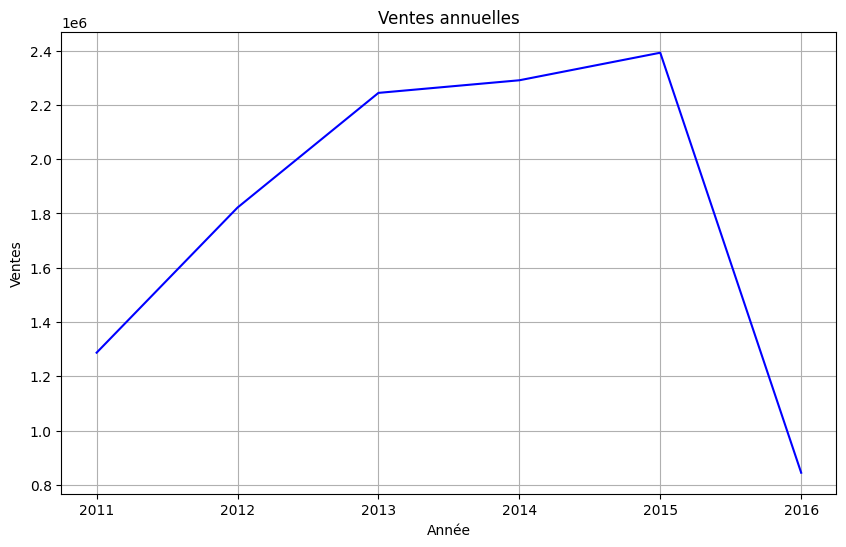

In [9]:
# Convertir la colonne 'date
flatten_sales['date'] = pd.to_datetime(flatten_sales['date'])

# Agréger les ventes par année
ventes_annuelles = flatten_sales.groupby(flatten_sales['date'].dt.year)['ventes'].sum()

# Tracer la série temporelle des ventes annuelles
plt.figure(figsize=(10, 6))
plt.plot(ventes_annuelles.index, ventes_annuelles.values, color='blue')
plt.title('Ventes annuelles')
plt.xlabel('Année')
plt.ylabel('Ventes')
plt.grid(True)
plt.show()

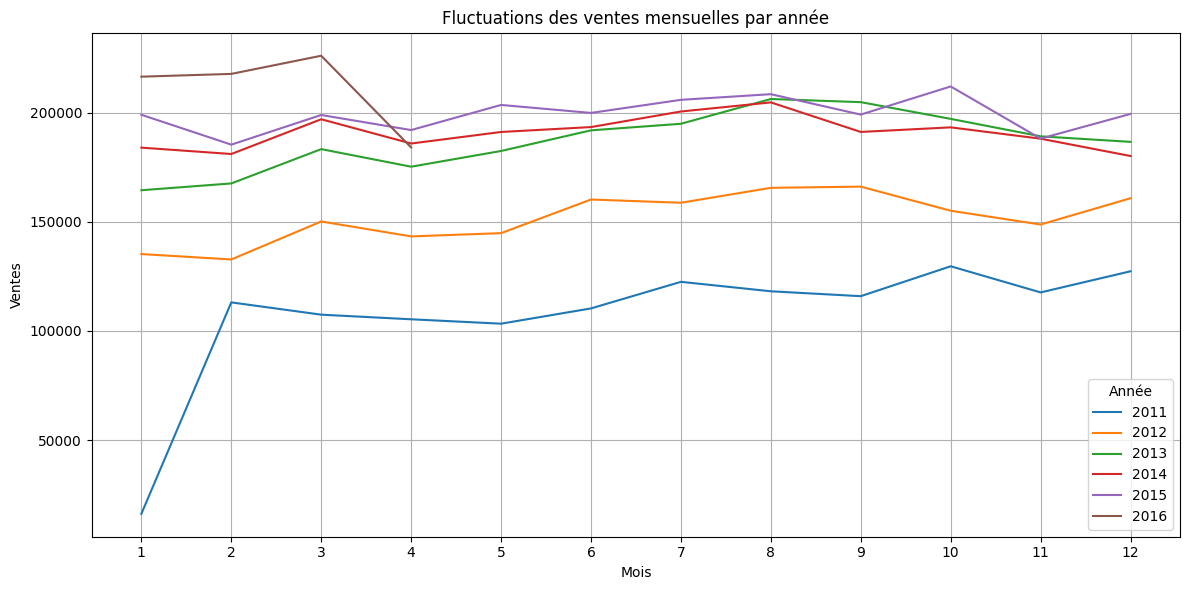

In [10]:
# Convertir la colonne 'date'
flatten_sales['date'] = pd.to_datetime(flatten_sales['date'])

# Agréger les ventes par mois et par année
ventes_mensuelles = flatten_sales.groupby([flatten_sales['date'].dt.year, flatten_sales['date'].dt.month])['ventes'].sum()

# Créer un DataFrame avec les ventes mensuelles
ventes_mensuelles_df = ventes_mensuelles.unstack(level=1)

# Tracer les fluctuations mensuelles pour chaque année
plt.figure(figsize=(12, 6))
for year in ventes_mensuelles_df.index:
    plt.plot(ventes_mensuelles_df.columns, ventes_mensuelles_df.loc[year], label=str(year))

plt.title('Fluctuations des ventes mensuelles par année')
plt.xlabel('Mois')
plt.ylabel('Ventes')
plt.legend(title='Année')
plt.grid(True)
plt.xticks(ventes_mensuelles_df.columns)
plt.tight_layout()
plt.show()

In [11]:
nobs_avant = flatten_sales.shape[0]
flatten_sales = flatten_sales.merge(true_start, how="inner", left_on=['store_id', 'item_id'], right_index=True)
flatten_sales = flatten_sales.loc[flatten_sales['date'] >= flatten_sales['min_date']]
nobs_apres = flatten_sales.shape[0]
print(f"{nobs_avant = } - {nobs_apres}")

nobs_avant = 10693670 - 8235969


# Etape n°4 : définir les limites du train et du test (nullifez la valeur "ventes" du test)

In [12]:
# Définir la date de séparation entre train et test
date_limite_test = '2016-02-05'

# Diviser les données en train et test
train_data = flatten_sales[flatten_sales['date'] < date_limite_test].copy()
test_data = flatten_sales[flatten_sales['date'] >= date_limite_test].copy()

# Nullifier les valeurs de ventes dans l'ensemble de test
test_data['ventes'] = None

#dimensions des ensembles de train et test
print("Dimension de l'ensemble d'entraînement:", train_data.shape)
print("Dimension de l'ensemble de test:", test_data.shape)

Dimension de l'ensemble d'entraînement: (7788781, 23)
Dimension de l'ensemble de test: (447188, 23)


# Etape n°5 : supprimez les produits qui n'ont pas été vendus depuis plus 90 jours

In [13]:
# Calculer la date maximale de vente pour chaque produit
max_sale_date_per_product = flatten_sales.groupby('item_id')['date'].max()

# Calculer le nombre de jours depuis la dernière vente pour chaque produit
days_since_last_sale = pd.Timestamp.now() - max_sale_date_per_product

# Identifier les produits qui n'ont pas été vendus depuis plus de 90 jours
products_to_remove = days_since_last_sale[days_since_last_sale > pd.Timedelta(days=90)].index

# Supprimer les produits de l'ensemble de données
filtered_sales = flatten_sales[~flatten_sales['item_id'].isin(products_to_remove)].copy()

# Vérifier la nouvelle taille de l'ensemble de données
print("Nombre d'entrées après suppression des produits non vendus depuis plus de 90 jours :", filtered_sales.shape[0])

Nombre d'entrées après suppression des produits non vendus depuis plus de 90 jours : 0


# Etape n°6 : Vérifiez la distribution des ventes par années, par moi, par catégorie (dept_id) et par marché (cat_id). Si vous constatez une incohérence ajustez votre données en conséquences 

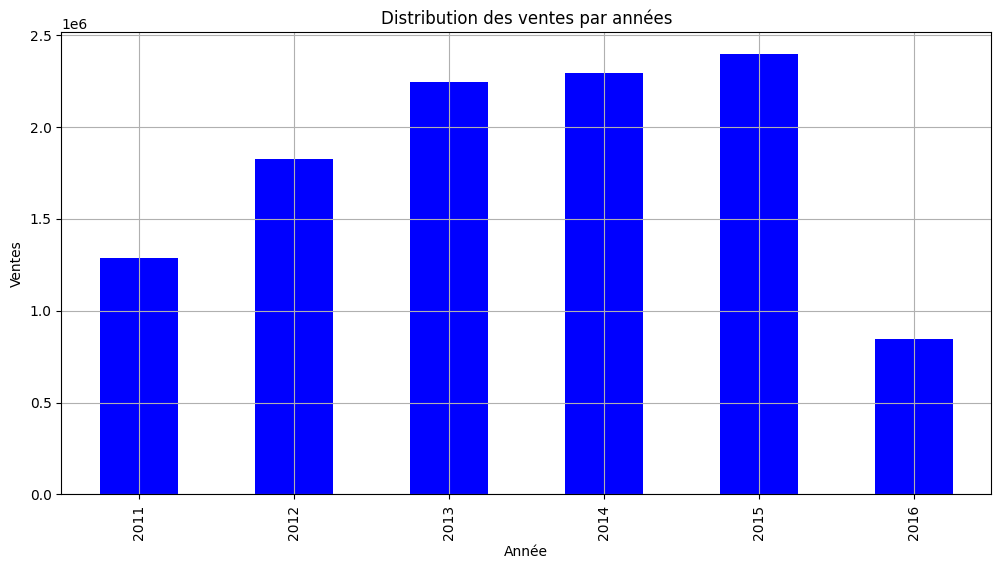

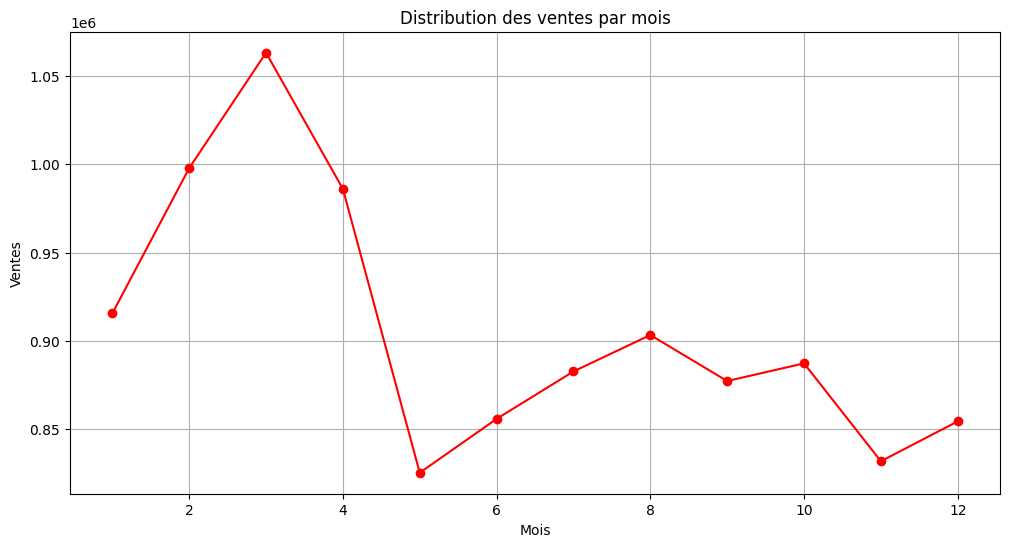

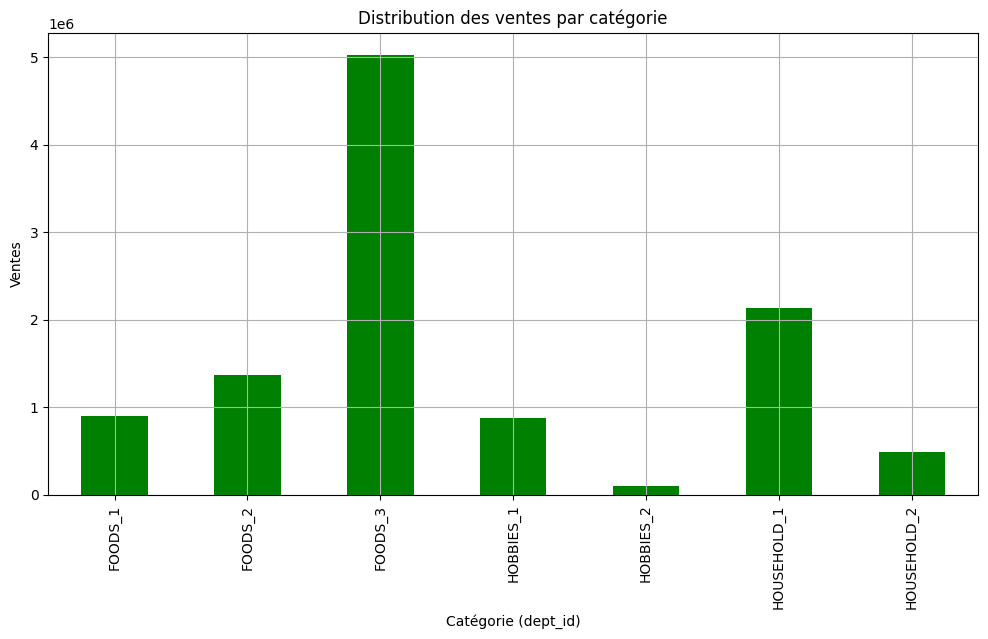

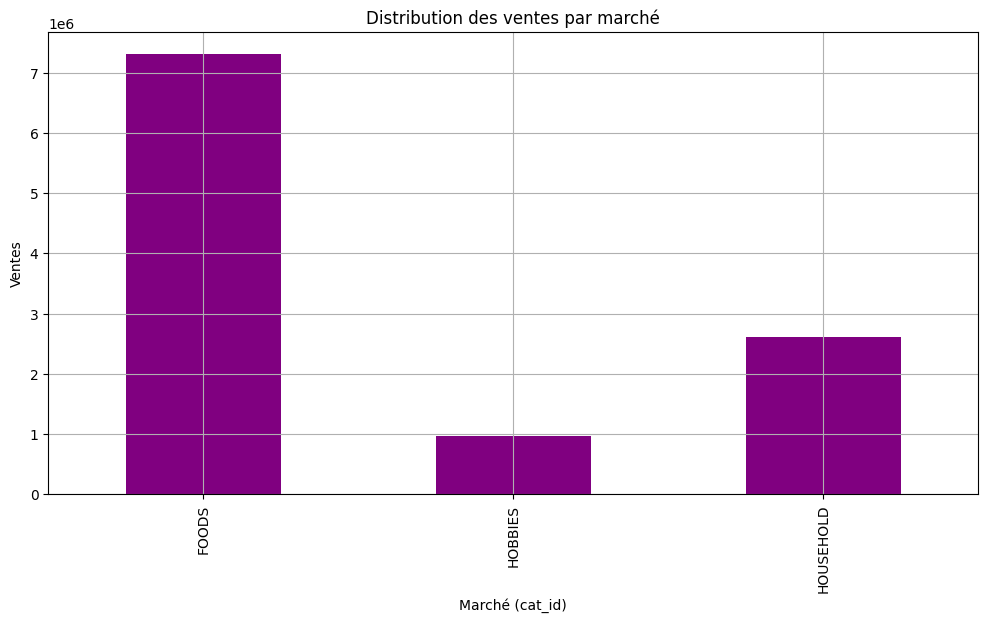

In [14]:
# Agréger les ventes par années, par mois, par catégorie et par marché
sales_distribution = flatten_sales.groupby([flatten_sales['date'].dt.year.rename('year'), flatten_sales['date'].dt.month.rename('month'), 'dept_id', 'cat_id'])['ventes'].sum().reset_index()

# Visualiser la distribution des ventes par années
plt.figure(figsize=(12, 6))
sales_distribution.groupby('year')['ventes'].sum().plot(kind='bar', color='blue')
plt.title('Distribution des ventes par années')
plt.xlabel('Année')
plt.ylabel('Ventes')
plt.grid(True)
plt.show()

# Visualiser la distribution des ventes par mois
plt.figure(figsize=(12, 6))
sales_distribution.groupby('month')['ventes'].sum().plot(kind='line', color='red', marker='o')
plt.title('Distribution des ventes par mois')
plt.xlabel('Mois')
plt.ylabel('Ventes')
plt.grid(True)
plt.show()

# Visualiser la distribution des ventes par catégorie (dept_id)
plt.figure(figsize=(12, 6))
sales_distribution.groupby('dept_id')['ventes'].sum().plot(kind='bar', color='green')
plt.title('Distribution des ventes par catégorie')
plt.xlabel('Catégorie (dept_id)')
plt.ylabel('Ventes')
plt.grid(True)
plt.show()

# Visualiser la distribution des ventes par marché (cat_id)
plt.figure(figsize=(12, 6))
sales_distribution.groupby('cat_id')['ventes'].sum().plot(kind='bar', color='purple')
plt.title('Distribution des ventes par marché')
plt.xlabel('Marché (cat_id)')
plt.ylabel('Ventes')
plt.grid(True)
plt.show()